In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from tqdm import tqdm

## Load dataset

In [3]:

def load_real_samples(path_to_subset):

    X=[]
    y=[]
    for folder in os.listdir(path_to_subset):
    
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            path_to_image = os.path.join(path_to_subset, folder, image)
    
            #check image none or not none
            img = cv2.imread(path_to_image)
            if img is not None:               
                img = cv2.resize(img, (32,32))
                x = (img - 127.5) / 127.5 
                X.append(x.astype(np.float32))
                y.append(folder)
    
    X=np.array(X)
    y=np.array(y)
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit and transform the labels into integers
    integer_encoded = label_encoder.fit_transform(y)
    Y=np.array(integer_encoded).reshape(-1,1).astype(np.uint8)   
    
    class_label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print(class_label_mapping)
    print(len(class_label_mapping))

    return [X,Y]




In [4]:
path_to_subset = '/kaggle/input/asl-sign-language-hand-landmarks-with-images/ASL-aplhabet-dataset-with_Hand landmark/train'

In [ ]:
ds=load_real_samples(path_to_subset)
print(ds[0].shape)
print(ds[1].shape)

## Discriminator

In [5]:
def define_discriminator(in_shape=(32,32,3), n_classes=28):

  # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 60)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)

	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(negative_slope=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(negative_slope=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# define model
    ##Combine input label with input image and supply as inputs to the model.
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [6]:

test_discr = define_discriminator()
print(test_discr.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 60)     │      1,680 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1024)   │     62,464 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 32, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32, 4) │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      4,736 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8192)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      8,193 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 224,657 (877.57 KB)

 Trainable params: 224,657 (877.57 KB)

 Non-trainable params: 0 (0.00 B)

None


## Generator

In [7]:
def define_generator(latent_dim, n_classes=28):

	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
	li = Embedding(n_classes, 100)(in_label) #Shape 1,50

	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)


	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer.
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(negative_slope=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128

	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(negative_slope=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(negative_slope=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

In [8]:
test_gen = define_generator(100, n_classes=28)
print(test_gen.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8192)      │    827,392 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │      2,800 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8192)      │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │      6,464 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 129) │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    264,320 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32, 3) │     24,579 │ leaky_re_lu_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,827 (5.29 MB)

 Trainable params: 1,387,827 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

None


## Combined model

In [9]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3

	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Define ganerater supportive functions

In [10]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

In [11]:
def generate_latent_points(latent_dim, n_samples, n_classes=28):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [12]:
# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

## Model Trainer

In [13]:
import gc
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                              #and a half batch of fake samples, combined a single batch.

    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    
    # manually enumerate epochs
    for i in tqdm(range(n_epochs)):
        # enumerate batches over the training set
        for j in range(bat_per_epo):

                  # Train the discriminator on real and fake images, separately (half batch each)
              #Research showed that separate training is more effective.
            # get randomly selected 'real' samples
                  # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

                  # update discriminator model weights
                  ##train_on_batch allows you to update weights based on a collection
                  #of samples you provide
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

                  #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

                  # The generator wants the discriminator to label the generated samples
              # as valid (ones)
              #This is where the generator is trying to trick discriminator into believing
              #the generated image is true (hence value of 1 for y)

                  # Generator is part of combined model where it got directly linked with the discriminator
              # Train the generator with latent_dim as x and 1 as y.
              # Again, 1 as the output as it is adversarial and if generator did a great
              #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # Print losses on this batch
            print(f"Epoch :{i+1} ,Batch :{j}/{bat_per_epo},Real_Loss:{ d_loss_real},Fake_Loss :{d_loss_fake},Gen_Loss;{ g_loss[0]} ")
            
            # Clear memory
            del X_real, labels_real, y_real, X_fake, labels, y_fake, z_input, labels_input,g_loss,d_loss_real,d_loss_fake
            gc.collect()

    # save the generator model
    g_model.save('ASL_GANs_V1.keras')

In [14]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset = load_real_samples(path_to_subset)

# train model
train(g_model, d_model, gan_model,dataset, latent_dim, n_epochs=8,n_batch=512)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'DEL': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'SPACE': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27}
28


  0%|          | 0/8 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
I0000 00:00:1733244298.775941    5133 service.cc:145] XLA service 0x7b6110005a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733244298.776008    5133 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733244300.391733    5133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
Epoch :0 ,Batch :0/65,Real_Loss:0.6958041787147522,Fake_Loss :0.6946468353271484,Gen_Loss;0.6946468353271484 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :0 ,Batch :1/65,Real_Loss:0.6957941055297852,Fake_Loss :0.696121096611023,Gen_Loss;0.696121096611023 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :0 ,Batch :2/65,Real_Loss:0.695112407207489,Fake_Loss :0.6961237788200378,Gen_Loss;0.6961237788200378 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :0 ,Batch :3/65,Real_Loss:0.6957394480705261,Fake_Loss :0.6969994902610779,Gen_Loss;0.6969994902610779 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :0 ,Batch :4/65,Real_Loss:0.6974037289619446,Fake_Loss :0.6989315748214722,Gen_Loss;0.6989315748214722 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :0 ,Batch :5/65,Real_Loss:0.6986454129219055,Fake_Loss :0.7004746794700623,Gen_Loss;0.7004746794700623 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :0 ,Batch :6/65,Real_Loss:0.7002354860305786,Fake_Loss :0.702408134937

 12%|█▎        | 1/8 [01:25<09:55, 85.05s/it]

Epoch :0 ,Batch :64/65,Real_Loss:0.9378803372383118,Fake_Loss :0.9427624344825745,Gen_Loss;0.9427624344825745 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :1 ,Batch :0/65,Real_Loss:0.9409055709838867,Fake_Loss :0.9456135630607605,Gen_Loss;0.9456135630607605 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :1 ,Batch :1/65,Real_Loss:0.9437475204467773,Fake_Loss :0.9485021233558655,Gen_Loss;0.9485021233558655 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :1 ,Batch :2/65,Real_Loss:0.946620523929596,Fake_Loss :0.9514245390892029,Gen_Loss;0.9514245390892029 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :1 ,Batch :3/65,Real_Loss:0.9495412111282349,Fake_Loss :0.9542823433876038,Gen_Loss;0.9542823433876038 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :1 ,Batch :4/65,Real_Loss:0.952394962310791,Fake_Loss :0.9570350646972656,Gen_Loss;0.9570350646972656 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :1 ,Batch :5/65,Real_Loss:0.9551863670349121,Fake_Loss :0.9598574638366699,Gen_Loss;0.9598574638366699 
8/8

 25%|██▌       | 2/8 [02:37<07:44, 77.44s/it]

Epoch :1 ,Batch :64/65,Real_Loss:1.0764893293380737,Fake_Loss :1.0794695615768433,Gen_Loss;1.0794695615768433 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :2 ,Batch :0/65,Real_Loss:1.0779938697814941,Fake_Loss :1.0810036659240723,Gen_Loss;1.0810036659240723 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :2 ,Batch :1/65,Real_Loss:1.0795398950576782,Fake_Loss :1.0825403928756714,Gen_Loss;1.0825403928756714 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :2 ,Batch :2/65,Real_Loss:1.0810797214508057,Fake_Loss :1.0840142965316772,Gen_Loss;1.0840142965316772 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :2 ,Batch :3/65,Real_Loss:1.0825668573379517,Fake_Loss :1.0854929685592651,Gen_Loss;1.0854929685592651 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :2 ,Batch :4/65,Real_Loss:1.084023356437683,Fake_Loss :1.0869801044464111,Gen_Loss;1.0869801044464111 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :2 ,Batch :5/65,Real_Loss:1.0855499505996704,Fake_Loss :1.0885382890701294,Gen_Loss;1.0885382890701294 
8/

 38%|███▊      | 3/8 [03:53<06:23, 76.78s/it]

Epoch :2 ,Batch :64/65,Real_Loss:1.1567679643630981,Fake_Loss :1.1589200496673584,Gen_Loss;1.1589200496673584 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :3 ,Batch :0/65,Real_Loss:1.157731056213379,Fake_Loss :1.1598871946334839,Gen_Loss;1.1598871946334839 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :3 ,Batch :1/65,Real_Loss:1.158713698387146,Fake_Loss :1.1608787775039673,Gen_Loss;1.1608787775039673 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :3 ,Batch :2/65,Real_Loss:1.1597013473510742,Fake_Loss :1.1618342399597168,Gen_Loss;1.1618342399597168 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :3 ,Batch :3/65,Real_Loss:1.160652756690979,Fake_Loss :1.1627774238586426,Gen_Loss;1.1627774238586426 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :3 ,Batch :4/65,Real_Loss:1.1615959405899048,Fake_Loss :1.1637011766433716,Gen_Loss;1.1637011766433716 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :3 ,Batch :5/65,Real_Loss:1.1625396013259888,Fake_Loss :1.1646817922592163,Gen_Loss;1.1646817922592163 
8/8 

 50%|█████     | 4/8 [05:12<05:11, 77.86s/it]

Epoch :3 ,Batch :64/65,Real_Loss:1.2093943357467651,Fake_Loss :1.2110471725463867,Gen_Loss;1.2110471725463867 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :4 ,Batch :0/65,Real_Loss:1.2100468873977661,Fake_Loss :1.2116947174072266,Gen_Loss;1.2116947174072266 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :4 ,Batch :1/65,Real_Loss:1.210705280303955,Fake_Loss :1.2123469114303589,Gen_Loss;1.2123469114303589 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :4 ,Batch :2/65,Real_Loss:1.2113673686981201,Fake_Loss :1.213016152381897,Gen_Loss;1.213016152381897 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :4 ,Batch :3/65,Real_Loss:1.2120378017425537,Fake_Loss :1.2136948108673096,Gen_Loss;1.2136948108673096 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :4 ,Batch :4/65,Real_Loss:1.2127095460891724,Fake_Loss :1.214351773262024,Gen_Loss;1.214351773262024 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :4 ,Batch :5/65,Real_Loss:1.2133708000183105,Fake_Loss :1.2149872779846191,Gen_Loss;1.2149872779846191 
8/8 ━━

 62%|██████▎   | 5/8 [06:35<03:59, 79.71s/it]

Epoch :4 ,Batch :64/65,Real_Loss:1.247840166091919,Fake_Loss :1.2492296695709229,Gen_Loss;1.2492296695709229 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :5 ,Batch :0/65,Real_Loss:1.2483742237091064,Fake_Loss :1.2497488260269165,Gen_Loss;1.2497488260269165 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :5 ,Batch :1/65,Real_Loss:1.2488998174667358,Fake_Loss :1.2502728700637817,Gen_Loss;1.2502728700637817 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :5 ,Batch :2/65,Real_Loss:1.2494229078292847,Fake_Loss :1.250810980796814,Gen_Loss;1.250810980796814 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :5 ,Batch :3/65,Real_Loss:1.24996817111969,Fake_Loss :1.2513463497161865,Gen_Loss;1.2513463497161865 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :5 ,Batch :4/65,Real_Loss:1.2504994869232178,Fake_Loss :1.2518702745437622,Gen_Loss;1.2518702745437622 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :5 ,Batch :5/65,Real_Loss:1.2510303258895874,Fake_Loss :1.252389669418335,Gen_Loss;1.252389669418335 
8/8 ━━━━

 75%|███████▌  | 6/8 [08:00<02:43, 81.51s/it]

Epoch :5 ,Batch :64/65,Real_Loss:1.278322696685791,Fake_Loss :1.2794784307479858,Gen_Loss;1.2794784307479858 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :6 ,Batch :0/65,Real_Loss:1.278729796409607,Fake_Loss :1.279885172843933,Gen_Loss;1.279885172843933 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :6 ,Batch :1/65,Real_Loss:1.2791434526443481,Fake_Loss :1.280304193496704,Gen_Loss;1.280304193496704 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :6 ,Batch :2/65,Real_Loss:1.2795593738555908,Fake_Loss :1.2807186841964722,Gen_Loss;1.2807186841964722 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :6 ,Batch :3/65,Real_Loss:1.2799681425094604,Fake_Loss :1.281107783317566,Gen_Loss;1.281107783317566 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :6 ,Batch :4/65,Real_Loss:1.2803667783737183,Fake_Loss :1.2815096378326416,Gen_Loss;1.2815096378326416 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch :6 ,Batch :5/65,Real_Loss:1.280767560005188,Fake_Loss :1.2818994522094727,Gen_Loss;1.2818994522094727 
8/8 ━━━━━━

 88%|████████▊ | 7/8 [09:32<01:24, 84.96s/it]

Epoch :6 ,Batch :64/65,Real_Loss:1.3016679286956787,Fake_Loss :1.3026421070098877,Gen_Loss;1.3026421070098877 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :7 ,Batch :0/65,Real_Loss:1.3019734621047974,Fake_Loss :1.302952527999878,Gen_Loss;1.302952527999878 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :7 ,Batch :1/65,Real_Loss:1.3022855520248413,Fake_Loss :1.3032736778259277,Gen_Loss;1.3032736778259277 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :7 ,Batch :2/65,Real_Loss:1.3026094436645508,Fake_Loss :1.303603172302246,Gen_Loss;1.303603172302246 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :7 ,Batch :3/65,Real_Loss:1.3029371500015259,Fake_Loss :1.3039164543151855,Gen_Loss;1.3039164543151855 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :7 ,Batch :4/65,Real_Loss:1.3032548427581787,Fake_Loss :1.3042385578155518,Gen_Loss;1.3042385578155518 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch :7 ,Batch :5/65,Real_Loss:1.303576946258545,Fake_Loss :1.3045616149902344,Gen_Loss;1.3045616149902344 
8/8 ━━

100%|██████████| 8/8 [11:07<00:00, 83.50s/it]

Epoch :7 ,Batch :64/65,Real_Loss:1.320051908493042,Fake_Loss :1.3209041357040405,Gen_Loss;1.3209041357040405 


## Predictions

In [18]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

In [20]:
# load model
model = load_model('/kaggle/working/ASL_GANs_V1.keras')

In [21]:
latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


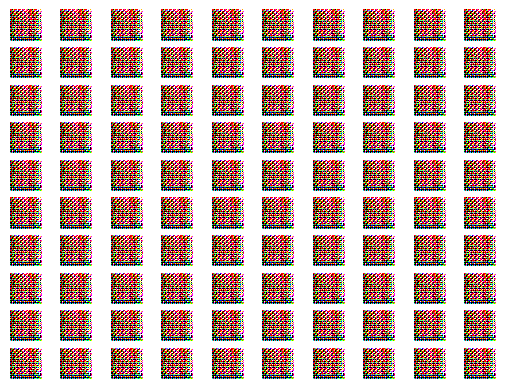

In [22]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 10)